In [1]:
from tqdm import tqdm
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

from src.const import AUDIO_PATH, MAIN_LABELS, BATCH_SIZE, VALIDATION_SPLIT, SEED

from src.preprocess import load_and_preprocess_for_binary_task

2024-04-15 21:54:30.094030: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 21:54:30.125967: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 21:54:30.259166: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 21:54:31.253762: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/telejkoi/.local/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/home/telejkoi/.local/lib/python3.10/site-packages/tensorflow_i

In [2]:
# for X, y in train_ds.take(1):
#     plt.plot(np.arange(0, len(X)), X.numpy())
from src.preprocess_utils import load_augmented_data


train_audio_with_augmented, train_labels_with_augmented = load_augmented_data()

In [3]:
train_audio_with_augmented.shape, train_labels_with_augmented.shape

((37902, 16000), (70728,))

### Unknown vs known task

In [2]:
train_ds, val_ds = load_and_preprocess_for_binary_task(plot_samples = True)

1
2


2024-04-15 21:48:16.390720: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 21:48:16.392172: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-04-15 21:48:16.430009: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2425728000 exceeds 10% of free system memory.


ValueError: Dimensions 37902 and 70728 are not compatible

In [16]:
# known_vs_unknown_train_ds = tf.data.Dataset.from_tensor_slices((train_audio_with_augmented, create_binary_labels(train_labels_with_augmented)))
# known_vs_unknown_val_ds = val_ds.map(lambda x, y: (x, map_val_labels(y)))

In [17]:
# spec_train_ds = transform_to_spectograms(known_vs_unknown_train_ds)
# spec_val_ds = transform_to_spectograms(known_vs_unknown_val_ds)

In [18]:
# spec_train_ds = spec_train_ds.map(
#     map_func=lambda audio,label: (tfio.audio.freq_mask(audio, param=5), label),
#     num_parallel_calls=tf.data.AUTOTUNE)

# spec_train_ds = spec_train_ds.map(
#     map_func=lambda audio,label: (tfio.audio.time_mask(audio, param=5), label),
#     num_parallel_calls=tf.data.AUTOTUNE)

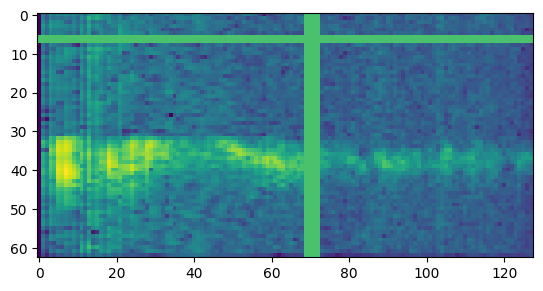

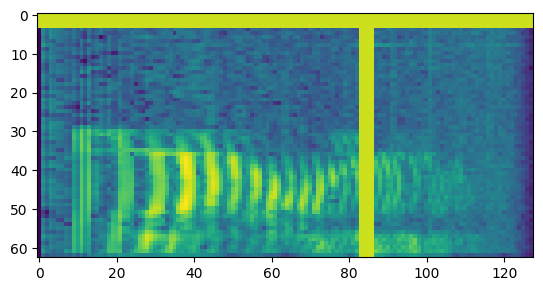

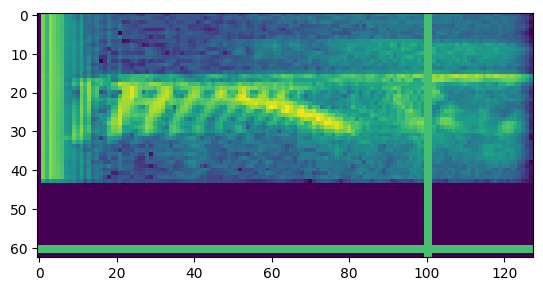

In [19]:
# for example_spec_audio, example_spec_labels in spec_train_ds.take(3):
#     plt.imshow(example_spec_audio.numpy())
#     plt.show()

In [20]:
# inputs = tf.keras.Input(shape=(32, 128))
# X = Conv1D(filters=1, kernel_size=5, activation='relu')(inputs)
# X = Dropout(0.1)(X)
# X1 = Bidirectional(LSTM(128), merge_mode="sum")(inputs)
# X = Add()([X1, inputs])
# X = Dense(units=128, activation="relu")(X)
# X = Dropout(rate=0.2)(X)
# X = Dense(units=64, activation="relu")(X)
# X = Dropout(rate=0.2)(X)
# X = Dense(units=11, activation="softmax", kernel_regularizer=l2(0.01))(X)
# outputs = X

# model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [21]:
input_shape=(63,128)
model = tf.keras.Sequential()
model.add(LSTM(128,input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(11, activation='softmax'))
# model.summary()

c:\Users\lukgr\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
known_vs_unknown_train_ds = spec_train_ds.cache().shuffle(100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
known_vs_unknown_val_ds = spec_val_ds.cache().prefetch(tf.data.AUTOTUNE)

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [ ]:
history = model.fit(known_vs_unknown_train_ds, epochs=50, validation_data=known_vs_unknown_val_ds)